# Coursera Captsone Final Project 

###### Importing necessary libraries

In [1]:
#import necessary libraries
from bs4 import BeautifulSoup
from urllib.request import urlopen
import lxml
import requests
import pandas as pd
import numpy as np
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
!conda install -c conda-forge folium=0.5.0 --yes
import folium

import matplotlib.pyplot as plt

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  47.48 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  36.27 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  40.11 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  46.41 MB/s


## Step 1: Getting gelocation data for New York City (for Bronx and Brooklyn)

**Using JSON file containing data and using it to create Pandas dataframe**

### Getting dataframe with NewYork neighbourhood and geolocation data

In [2]:
#Download data from the link
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

#Loading JSON data into object/variable to use
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
#Exploring structure
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

Data downloaded!


{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

**Getting dataframe from object containing JSON data**

In [3]:
#define the dataframe columns
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 

# instantiate the empty dataframe with desired columns
df_nyc = pd.DataFrame(columns=column_names)
df_nyc

,Borough,Neighbourhood,Latitude,Longitude


In [4]:
#loop through onject file to fill empty datafranmw we just created

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_nyc = df_nyc.append({'Borough': borough,
                                          'Neighbourhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
df_nyc.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


**Filter for rows where Borough is Bronx or Brooklyn**

In [5]:
df_Bro = df_nyc[df_nyc['Borough'] == 'Brooklyn'].reset_index(drop=True) #only taking data for neighbourhoods in Brooklyn
df_Bro = df_Bro.append(df_nyc[df_nyc['Borough'] == 'Bronx'])  # adding data for Bronx

print(df_Bro.shape)
df_Bro.head()

(122, 4)


,Borough,Neighbourhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


#### Vizualizing neighbourhoods on map

In [6]:
# create map

address = 'Manhattan, New Work'   #using Manhattan to center map for boroughs north and south of manhattan
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
ny_lat = location.latitude
ny_lon = location.longitude


map_clusters_nyc = folium.Map(location=[ny_lat, ny_lon], zoom_start=10)


# add markers to the map
markers_colors = []
for lat, lon, poi in zip(df_Bro['Latitude'], df_Bro['Longitude'], df_Bro['Neighbourhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters_nyc)
       
map_clusters_nyc

## Step 2: Getting venues data from FourSquare

### 2A. FourSquare Credentialing and creating function to be used later

In [7]:
#sample code for credentialing, actual code hidden below

CLIENT_ID = 'Your Cliend Id' # your Foursquare ID
CLIENT_SECRET = 'Your Cliend secret' # your Foursquare Secret
VERSION = 'version' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Your Cliend Id
CLIENT_SECRET:Your Cliend secret


In [8]:
# The code was removed by Watson Studio for sharing.

In [9]:
# creating a function to use this with multiple neighbourhoods

LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, boroughs, radius=500):
    
    venues_list=[]
    for name, lat, lng, bor in zip(names, latitudes, longitudes, boroughs):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue # appending values retrived from JSON
        venues_list.append([(
            name, 
            lat, 
            lng, 
            bor,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 'Borough',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### 2B. Using function on neighbourhoods in two boroughs and getting venues data for neighbourhoods

In [11]:
nyc_venues = getNearbyVenues(names=df_Bro['Neighbourhood'],
                                   latitudes=df_Bro['Latitude'],
                                   longitudes=df_Bro['Longitude'],
                                     boroughs=df_Bro['Borough'])

# check shape and first 5 rows of column

print(nyc_venues.shape)

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus
Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway

In [12]:
nyc_venues.head(10)  #dataframe is a consist of venues retunred by API and function created

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Brooklyn,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Brooklyn,Cocoa Grinder,40.623967,-74.030863,Juice Bar
2,Bay Ridge,40.625801,-74.030621,Brooklyn,Bagel Boy,40.627896,-74.029335,Bagel Shop
3,Bay Ridge,40.625801,-74.030621,Brooklyn,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot
4,Bay Ridge,40.625801,-74.030621,Brooklyn,Ho' Brah Taco Joint,40.622960,-74.031371,Taco Place
5,Bay Ridge,40.625801,-74.030621,Brooklyn,XIN,40.625082,-74.030494,Chinese Restaurant
6,Bay Ridge,40.625801,-74.030621,Brooklyn,Leo's Casa Calamari,40.623348,-74.031082,Pizza Place
7,Bay Ridge,40.625801,-74.030621,Brooklyn,Brooklyn Market,40.626939,-74.029948,Grocery Store
8,Bay Ridge,40.625801,-74.030621,Brooklyn,Karam,40.622931,-74.028316,Middle Eastern Restaurant
9,Bay Ridge,40.625801,-74.030621,Brooklyn,A.L.C. Italian Grocery,40.623051,-74.031224,Grocery Store


**Histogram of how many venues nighbourhoods have (as returned by FourSquare API)**

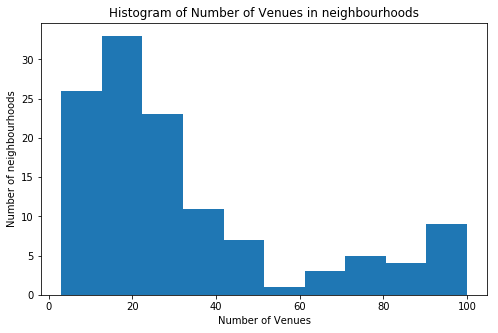

In [13]:
counts = nyc_venues.groupby('Neighbourhood').count()  #storing count from one column to a new dataframe

counts['Venue'].plot(kind='hist', figsize=(8, 5))
plt.title('Histogram of Number of Venues in neighbourhoods') # add a title to the histogram
plt.ylabel('Number of neighbourhoods') # add y-label
plt.xlabel('Number of Venues') # add x-label

plt.show()

### 2C. Data Cleaning and Feature Engineering to make data ready for KNN

In [14]:
# one hot encoding catagories to better be able to use K-means - feature engineering
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighbourhood'] = nyc_venues['Neighbourhood'] 



# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

print(nyc_onehot.shape)
nyc_onehot.head()

(4026, 315)


,Neighbourhood,Accessories Store,Adult Boutique,African Restaurant,Airport Tram,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bay Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# group by nightbourhoods to see how many venues catagories in different neighbourhoods

nyc_grouped = nyc_onehot.groupby('Neighbourhood').mean().reset_index()

borough = df_Bro.iloc[:, 0:2]

nyc_grouped = pd.merge(nyc_grouped, borough, how='outer')

print(nyc_grouped.shape)

nyc_grouped.head()

(122, 316)


,Neighbourhood,Accessories Store,Adult Boutique,African Restaurant,Airport Tram,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Borough
0,Allerton,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,Bronx
1,Bath Beach,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039216,0.0,Brooklyn
2,Bay Ridge,0.0,0.0,0.0,0.0,0.034483,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,Brooklyn
3,Baychester,0.0,0.0,0.0,0.0,0.052632,0.0,0.052632,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,Bronx
4,Bedford Park,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,Bronx


### Some cleaning

In [65]:
nyc_grouped.dropna(inplace=True)  #dropping a few records with NaN values
nyc_grouped.head(10)
#nyc_grouped['Borough']

,Neighbourhood,Accessories Store,Adult Boutique,African Restaurant,Airport Tram,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Borough
0,Allerton,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Bronx
1,Bath Beach,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.039216,0.000000,Brooklyn
2,Bay Ridge,0.0,0.0,0.0,0.0,0.034483,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Brooklyn
3,Baychester,0.0,0.0,0.0,0.0,0.052632,0.000000,0.052632,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Bronx
4,Bedford Park,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Bronx
5,Bedford Stuyvesant,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.037037,0.037037,0.000000,0.000000,0.000000,Brooklyn
6,Belmont,0.0,0.0,0.0,0.0,0.021053,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.010526,0.000000,0.000000,Bronx
7,Bensonhurst,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Brooklyn
8,Bergen Beach,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Brooklyn
9,Boerum Hill,0.0,0.0,0.0,0.0,0.012346,0.012346,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.012346,0.000000,0.000000,0.024691,Brooklyn


In [66]:
city = nyc_grouped['Borough']   #creating object containing city column 
neigh = nyc_grouped['Neighbourhood'] #creating object containing neighbourhood column
nyc_grouped.drop(labels = ['Borough', 'Neighbourhood'], axis=1, inplace=True)
nyc_grouped = nyc_grouped.astype('float64')  #converting all columns (except for Borough and Neighbourhood) to float for knn to avoid object type error
nyc_grouped.insert(0,'Neighbourhood', neigh) #inserting back neighbourhood
nyc_grouped.insert(1,'Borough', city) #inserting back borough
nyc_grouped.head()

,Neighbourhood,Borough,Accessories Store,Adult Boutique,African Restaurant,Airport Tram,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Allerton,Bronx,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Bath Beach,Brooklyn,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039216,0.0
2,Bay Ridge,Brooklyn,0.0,0.0,0.0,0.0,0.034483,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Baychester,Bronx,0.0,0.0,0.0,0.0,0.052632,0.0,0.052632,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Bedford Park,Bronx,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [67]:
nyc_grouped.insert(2, 'Has Ice Cream Shops?', nyc_grouped['Ice Cream Shop']!= 0)  #creating colum storing if neighbourhood has non zero value for Ice Cream Shops to use later
nyc_grouped.head()

,Neighbourhood,Borough,Has Ice Cream Shops?,Accessories Store,Adult Boutique,African Restaurant,Airport Tram,American Restaurant,Antique Shop,Arcade,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Allerton,Bronx,False,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Bath Beach,Brooklyn,True,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039216,0.0
2,Bay Ridge,Brooklyn,True,0.0,0.0,0.0,0.0,0.034483,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Baychester,Bronx,False,0.0,0.0,0.0,0.0,0.052632,0.0,0.052632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Bedford Park,Bronx,False,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### 2D. Although we have a dataframe for K-Means, to better display the final results creating another dataframe

In [68]:
#
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood', 'Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
merged_venues_sorted = pd.DataFrame(columns=columns)
merged_venues_sorted['Neighbourhood'] = nyc_grouped['Neighbourhood']
merged_venues_sorted['Borough'] = nyc_grouped['Borough']

for ind in np.arange(nyc_grouped.shape[0]):
    merged_venues_sorted.iloc[ind, 2:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

print(merged_venues_sorted.shape)
merged_venues_sorted.head()

(122, 12)


,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Bronx,Pizza Place,Supermarket,Deli / Bodega,Spa,Cosmetics Shop,Chinese Restaurant,Electronics Store,Spanish Restaurant,Fried Chicken Joint,Playground
1,Bath Beach,Brooklyn,Pharmacy,Donut Shop,Italian Restaurant,Women's Store,Cantonese Restaurant,Kids Store,Fast Food Restaurant,Chinese Restaurant,Sushi Restaurant,Pizza Place
2,Bay Ridge,Brooklyn,Italian Restaurant,Spa,Pizza Place,Bagel Shop,Bar,Greek Restaurant,American Restaurant,Playground,Chinese Restaurant,Grocery Store
3,Baychester,Bronx,Electronics Store,Spanish Restaurant,Gym / Fitness Center,Men's Store,Sandwich Place,Mexican Restaurant,Mattress Store,Supermarket,Pet Store,Donut Shop
4,Bedford Park,Bronx,Deli / Bodega,Diner,Pharmacy,Mexican Restaurant,Chinese Restaurant,Pizza Place,Bus Station,Supermarket,Sandwich Place,Baseball Field


## Step 3. Finally to K-means clustering to see what neighbourhoods are close to each other in characteristics

**Importing and applying Kmeans Algorithm**

In [48]:
#importing Kmeans
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

merged_df_clustering = nyc_grouped.drop(columns= ['Neighbourhood','Borough', 'Has Ice Cream Shops?'], axis=1)   #creating dataframe without non-numeric and irrelevent columns for KNN algorithm
#print(merged_df_clustering.head())


# run k-means clustering
KMEANS = KMeans(n_clusters=kclusters, random_state=0).fit(merged_df_clustering)

# check cluster labels generated by algorithm
KMEANS.labels_[0:10]

array([1, 3, 3, 3, 1, 3, 3, 3, 3, 3], dtype=int32)

**Create dataframe with cluster labels and most common venue catagories**

In [69]:
# add clustering labels
merged_venues_sorted.insert(0, 'Cluster Labels', KMEANS.labels_)  #inserting Kmeans labels
merged_df_withclust = df_Bro      

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged_df_withclust = merged_venues_sorted.merge(merged_df_withclust)

merged_df_withclust.head()

,Cluster Labels,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,1,Allerton,Bronx,Pizza Place,Supermarket,Deli / Bodega,Spa,Cosmetics Shop,Chinese Restaurant,Electronics Store,Spanish Restaurant,Fried Chicken Joint,Playground,40.865788,-73.859319
1,3,Bath Beach,Brooklyn,Pharmacy,Donut Shop,Italian Restaurant,Women's Store,Cantonese Restaurant,Kids Store,Fast Food Restaurant,Chinese Restaurant,Sushi Restaurant,Pizza Place,40.599519,-73.998752
2,3,Bay Ridge,Brooklyn,Italian Restaurant,Spa,Pizza Place,Bagel Shop,Bar,Greek Restaurant,American Restaurant,Playground,Chinese Restaurant,Grocery Store,40.625801,-74.030621
3,3,Baychester,Bronx,Electronics Store,Spanish Restaurant,Gym / Fitness Center,Men's Store,Sandwich Place,Mexican Restaurant,Mattress Store,Supermarket,Pet Store,Donut Shop,40.866858,-73.835798
4,1,Bedford Park,Bronx,Deli / Bodega,Diner,Pharmacy,Mexican Restaurant,Chinese Restaurant,Pizza Place,Bus Station,Supermarket,Sandwich Place,Baseball Field,40.870185,-73.885512


In [50]:
merged_df_withclust.head()

,Cluster Labels,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,1,Allerton,Bronx,Pizza Place,Supermarket,Deli / Bodega,Spa,Cosmetics Shop,Chinese Restaurant,Electronics Store,Spanish Restaurant,Fried Chicken Joint,Playground,40.865788,-73.859319
1,3,Bath Beach,Brooklyn,Pharmacy,Donut Shop,Italian Restaurant,Women's Store,Cantonese Restaurant,Kids Store,Fast Food Restaurant,Chinese Restaurant,Sushi Restaurant,Pizza Place,40.599519,-73.998752
2,3,Bay Ridge,Brooklyn,Italian Restaurant,Spa,Pizza Place,Bagel Shop,Bar,Greek Restaurant,American Restaurant,Playground,Chinese Restaurant,Grocery Store,40.625801,-74.030621
3,3,Baychester,Bronx,Electronics Store,Spanish Restaurant,Gym / Fitness Center,Men's Store,Sandwich Place,Mexican Restaurant,Mattress Store,Supermarket,Pet Store,Donut Shop,40.866858,-73.835798
4,1,Bedford Park,Bronx,Deli / Bodega,Diner,Pharmacy,Mexican Restaurant,Chinese Restaurant,Pizza Place,Bus Station,Supermarket,Sandwich Place,Baseball Field,40.870185,-73.885512


**Checking the clusters**

In [51]:
merged_df_withclust.loc[merged_df_withclust['Cluster Labels'] == 0, merged_df_withclust.columns[[1] + list(range(2, merged_df_withclust.shape[1]))]]

,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
17,Canarsie,Brooklyn,Chinese Restaurant,Caribbean Restaurant,Thai Restaurant,Gym,Bus Line,Asian Restaurant,Flower Shop,Filipino Restaurant,Film Studio,Fish & Chips Shop,40.635564,-73.902093
86,Paerdegat Basin,Brooklyn,Food,Asian Restaurant,Bus Line,Chinese Restaurant,Yoga Studio,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,40.631318,-73.902335


In [52]:
merged_df_withclust.loc[merged_df_withclust['Cluster Labels'] == 1, merged_df_withclust.columns[[1] + list(range(2, merged_df_withclust.shape[1]))]]

,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,Allerton,Bronx,Pizza Place,Supermarket,Deli / Bodega,Spa,Cosmetics Shop,Chinese Restaurant,Electronics Store,Spanish Restaurant,Fried Chicken Joint,Playground,40.865788,-73.859319
4,Bedford Park,Bronx,Deli / Bodega,Diner,Pharmacy,Mexican Restaurant,Chinese Restaurant,Pizza Place,Bus Station,Supermarket,Sandwich Place,Baseball Field,40.870185,-73.885512
10,Borough Park,Brooklyn,Pizza Place,Bank,Deli / Bodega,Pharmacy,Coffee Shop,Café,Fast Food Restaurant,Bike Shop,Metro Station,Restaurant,40.633131,-73.990498
19,Castle Hill,Bronx,Deli / Bodega,Cosmetics Shop,Bank,Latin American Restaurant,Pharmacy,Pizza Place,Market,Diner,Food Truck,French Restaurant,40.819014,-73.848027
22,Claremont Village,Bronx,Chinese Restaurant,Grocery Store,Bakery,Pizza Place,Bus Station,Restaurant,Liquor Store,Gym,Caribbean Restaurant,Gift Shop,40.831428,-73.901199
25,Co-op City,Bronx,Park,Accessories Store,Baseball Field,Ice Cream Shop,Discount Store,Grocery Store,Pizza Place,Mattress Store,Restaurant,Bus Station,40.874294,-73.829939
28,Concourse Village,Bronx,Pizza Place,Deli / Bodega,Fast Food Restaurant,Sporting Goods Shop,Convenience Store,Pharmacy,Supermarket,Mexican Restaurant,Office,Donut Shop,40.824780,-73.915847
31,Crown Heights,Brooklyn,Pizza Place,Café,Museum,Bagel Shop,Playground,Salon / Barbershop,Bakery,Candy Store,Coffee Shop,Liquor Store,40.670829,-73.943291
39,East Tremont,Bronx,Pizza Place,Donut Shop,Supermarket,Café,Shoe Store,Mexican Restaurant,Lounge,Bank,Mobile Phone Shop,Paella Restaurant,40.842696,-73.887356
55,Gravesend,Brooklyn,Pizza Place,Italian Restaurant,Bakery,Bus Station,Chinese Restaurant,Lounge,Metro Station,Men's Store,Gift Shop,Grocery Store,40.595260,-73.973471


In [53]:
merged_df_withclust.loc[merged_df_withclust['Cluster Labels'] == 2, merged_df_withclust.columns[[1] + list(range(2, merged_df_withclust.shape[1]))]]

,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
12,Broadway Junction,Brooklyn,Caribbean Restaurant,Diner,Donut Shop,Deli / Bodega,Pizza Place,Moving Target,Burger Joint,Sandwich Place,Dry Cleaner,Fried Chicken Joint,40.677861,-73.903317
27,Concourse,Bronx,Deli / Bodega,Pizza Place,Bakery,Italian Restaurant,Art Museum,Caribbean Restaurant,Check Cashing Service,Sandwich Place,Grocery Store,Pharmacy,40.834284,-73.915589
32,Cypress Hills,Brooklyn,Fast Food Restaurant,Latin American Restaurant,Ice Cream Shop,Donut Shop,Deli / Bodega,Metro Station,Fried Chicken Joint,Spanish Restaurant,Pizza Place,Seafood Restaurant,40.682391,-73.876616
38,East New York,Brooklyn,Deli / Bodega,Fast Food Restaurant,Asian Restaurant,Gym,Plaza,Pizza Place,Convenience Store,Business Service,Metro Station,Filipino Restaurant,40.669926,-73.880699
41,Eastchester,Bronx,Caribbean Restaurant,Diner,Metro Station,Bus Station,Donut Shop,Fast Food Restaurant,Convenience Store,Bowling Alley,Chinese Restaurant,Seafood Restaurant,40.887556,-73.827806
42,Edenwald,Bronx,Supermarket,Grocery Store,Fish Market,Food,Deli / Bodega,Ice Cream Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,40.884561,-73.848083
47,Flatlands,Brooklyn,Fast Food Restaurant,Pharmacy,Caribbean Restaurant,Bar,Fried Chicken Joint,Paper / Office Supplies Store,Athletics & Sports,Park,Lounge,Video Store,40.630446,-73.929113
64,Longwood,Bronx,Deli / Bodega,Diner,Grocery Store,Sandwich Place,Donut Shop,Community Center,Latin American Restaurant,Flower Shop,Field,Filipino Restaurant,40.815099,-73.895788
65,Madison,Brooklyn,Deli / Bodega,Bagel Shop,Hobby Shop,Dessert Shop,Pizza Place,Pilates Studio,Candy Store,Spa,Italian Restaurant,Hot Dog Joint,40.609378,-73.948415
78,Mount Hope,Bronx,Deli / Bodega,Donut Shop,Spanish Restaurant,Supermarket,Grocery Store,Sandwich Place,Video Game Store,Fried Chicken Joint,Ice Cream Shop,Distillery,40.848842,-73.908299


In [54]:
merged_df_withclust.loc[merged_df_withclust['Cluster Labels'] == 3, merged_df_withclust.columns[[1] + list(range(2, merged_df_withclust.shape[1]))]]

,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
1,Bath Beach,Brooklyn,Pharmacy,Donut Shop,Italian Restaurant,Women's Store,Cantonese Restaurant,Kids Store,Fast Food Restaurant,Chinese Restaurant,Sushi Restaurant,Pizza Place,40.599519,-73.998752
2,Bay Ridge,Brooklyn,Italian Restaurant,Spa,Pizza Place,Bagel Shop,Bar,Greek Restaurant,American Restaurant,Playground,Chinese Restaurant,Grocery Store,40.625801,-74.030621
3,Baychester,Bronx,Electronics Store,Spanish Restaurant,Gym / Fitness Center,Men's Store,Sandwich Place,Mexican Restaurant,Mattress Store,Supermarket,Pet Store,Donut Shop,40.866858,-73.835798
5,Bedford Stuyvesant,Brooklyn,Coffee Shop,Bar,Café,Pizza Place,Wine Bar,Park,Fruit & Vegetable Store,Bus Stop,New American Restaurant,Boutique,40.687232,-73.941785
6,Belmont,Bronx,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Grocery Store,Dessert Shop,Food & Drink Shop,Sandwich Place,Bank,Spanish Restaurant,40.857277,-73.888452
7,Bensonhurst,Brooklyn,Ice Cream Shop,Grocery Store,Chinese Restaurant,Sushi Restaurant,Liquor Store,Cosmetics Shop,Supermarket,Spa,Butcher,Shabu-Shabu Restaurant,40.611009,-73.995180
8,Bergen Beach,Brooklyn,Harbor / Marina,Baseball Field,Playground,Athletics & Sports,Donut Shop,Food,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,40.615150,-73.898556
9,Boerum Hill,Brooklyn,Coffee Shop,Spa,Bar,French Restaurant,Dance Studio,Yoga Studio,Cocktail Bar,Middle Eastern Restaurant,Martial Arts Dojo,Kids Store,40.685683,-73.983748
11,Brighton Beach,Brooklyn,Eastern European Restaurant,Restaurant,Beach,Bank,Mobile Phone Shop,Neighborhood,Pharmacy,Gourmet Shop,Sushi Restaurant,Russian Restaurant,40.576825,-73.965094
13,Bronxdale,Bronx,Italian Restaurant,Eastern European Restaurant,Gym,School,Chinese Restaurant,Spanish Restaurant,Bank,Bakery,Mexican Restaurant,Park,40.852723,-73.861726


In [55]:
merged_df_withclust.loc[merged_df_withclust['Cluster Labels'] == 4, merged_df_withclust.columns[[1] + list(range(2, merged_df_withclust.shape[1]))]]

,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
45,Fieldston,Bronx,Plaza,Playground,River,Yoga Studio,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,40.895437,-73.905643


**Creating map with clusters colored based on their cluster number**

In [56]:
# defining variables to create map

address = 'Bronx, New Work'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
ny_lat = location.latitude
ny_lon = location.longitude

#creating map object
map_clusters_nyc = folium.Map(location=[ny_lat, ny_lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_df_withclust['Latitude'], merged_df_withclust['Longitude'], merged_df_withclust['Neighbourhood'], merged_df_withclust['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_nyc)
       
map_clusters_nyc

In [57]:
# defining variables to create map

address = 'Bronx, New Work'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
ny_lat = location.latitude
ny_lon = location.longitude

#creating map object
map_clusters_nyc = folium.Map(location=[ny_lat, ny_lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged_df_withclust['Latitude'], merged_df_withclust['Longitude'], merged_df_withclust['Neighbourhood'], merged_df_withclust['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_nyc)
       
map_clusters_nyc

**Getting datafrae containing nrighourhoods: Mount Hope from Bronx and all Brooklyn neighbourhoods belonging to Cluster 2**

In [58]:
results = merged_df_withclust.loc[merged_df_withclust['Cluster Labels'] == 2, 
        merged_df_withclust.columns[[1] + list(range(2, merged_df_withclust.shape[1]))]]

results.sort_values('Borough', inplace=True)

mthope= results.loc[results['Neighbourhood'] == 'Mount Hope']
results = results.loc[results['Borough'] == 'Brooklyn']
results = results.append(mthope, ignore_index=True)

results

,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,Rugby,Brooklyn,Caribbean Restaurant,Supermarket,Sandwich Place,Mobile Phone Shop,Fast Food Restaurant,Fried Chicken Joint,Bank,Bakery,Coffee Shop,Grocery Store,40.655572,-73.926882
1,Remsen Village,Brooklyn,Caribbean Restaurant,Fast Food Restaurant,Breakfast Spot,Liquor Store,Donut Shop,Pharmacy,Coffee Shop,Sandwich Place,Fish Market,Fried Chicken Joint,40.652117,-73.916653
2,Broadway Junction,Brooklyn,Caribbean Restaurant,Diner,Donut Shop,Deli / Bodega,Pizza Place,Moving Target,Burger Joint,Sandwich Place,Dry Cleaner,Fried Chicken Joint,40.677861,-73.903317
3,Madison,Brooklyn,Deli / Bodega,Bagel Shop,Hobby Shop,Dessert Shop,Pizza Place,Pilates Studio,Candy Store,Spa,Italian Restaurant,Hot Dog Joint,40.609378,-73.948415
4,Flatlands,Brooklyn,Fast Food Restaurant,Pharmacy,Caribbean Restaurant,Bar,Fried Chicken Joint,Paper / Office Supplies Store,Athletics & Sports,Park,Lounge,Video Store,40.630446,-73.929113
5,East New York,Brooklyn,Deli / Bodega,Fast Food Restaurant,Asian Restaurant,Gym,Plaza,Pizza Place,Convenience Store,Business Service,Metro Station,Filipino Restaurant,40.669926,-73.880699
6,Cypress Hills,Brooklyn,Fast Food Restaurant,Latin American Restaurant,Ice Cream Shop,Donut Shop,Deli / Bodega,Metro Station,Fried Chicken Joint,Spanish Restaurant,Pizza Place,Seafood Restaurant,40.682391,-73.876616
7,Ocean Hill,Brooklyn,Deli / Bodega,Fried Chicken Joint,Southern / Soul Food Restaurant,Supermarket,Bus Stop,Park,Food,Metro Station,Seafood Restaurant,Market,40.678403,-73.913068
8,Wingate,Brooklyn,Fast Food Restaurant,Donut Shop,Field,Liquor Store,Gym / Fitness Center,Fish & Chips Shop,Café,BBQ Joint,Health & Beauty Service,Bus Station,40.660947,-73.937187
9,Mount Hope,Bronx,Deli / Bodega,Donut Shop,Spanish Restaurant,Supermarket,Grocery Store,Sandwich Place,Video Game Store,Fried Chicken Joint,Ice Cream Shop,Distillery,40.848842,-73.908299


**creating map for just these neighbourhoods**

In [59]:
# create map

address = 'Brooklyn, New Work'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
ny_lat = location.latitude
ny_lon = location.longitude


map_clusters_nyc = folium.Map(location=[ny_lat, ny_lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi in zip(results['Latitude'], results['Longitude'], results['Neighbourhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters_nyc)
       
map_clusters_nyc

**Adding back columns containing information on ice cream shops in neighbourhoods**

In [60]:
#adding columns containing information whether ice cream shop exist in the area and relative frequency if exist

tempDF = nyc_grouped[['Neighbourhood','Has Ice Cream Shops?','Ice Cream Shop']].copy() # temp dataframe containing two columns
final_merged = results.merge(tempDF) # merging 

final_merged 

,Neighbourhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude,Has Ice Cream Shops?,Ice Cream Shop
0,Rugby,Brooklyn,Caribbean Restaurant,Supermarket,Sandwich Place,Mobile Phone Shop,Fast Food Restaurant,Fried Chicken Joint,Bank,Bakery,Coffee Shop,Grocery Store,40.655572,-73.926882,True,0.052632
1,Remsen Village,Brooklyn,Caribbean Restaurant,Fast Food Restaurant,Breakfast Spot,Liquor Store,Donut Shop,Pharmacy,Coffee Shop,Sandwich Place,Fish Market,Fried Chicken Joint,40.652117,-73.916653,False,0.000000
2,Broadway Junction,Brooklyn,Caribbean Restaurant,Diner,Donut Shop,Deli / Bodega,Pizza Place,Moving Target,Burger Joint,Sandwich Place,Dry Cleaner,Fried Chicken Joint,40.677861,-73.903317,True,0.071429
3,Madison,Brooklyn,Deli / Bodega,Bagel Shop,Hobby Shop,Dessert Shop,Pizza Place,Pilates Studio,Candy Store,Spa,Italian Restaurant,Hot Dog Joint,40.609378,-73.948415,False,0.000000
4,Flatlands,Brooklyn,Fast Food Restaurant,Pharmacy,Caribbean Restaurant,Bar,Fried Chicken Joint,Paper / Office Supplies Store,Athletics & Sports,Park,Lounge,Video Store,40.630446,-73.929113,False,0.000000
5,East New York,Brooklyn,Deli / Bodega,Fast Food Restaurant,Asian Restaurant,Gym,Plaza,Pizza Place,Convenience Store,Business Service,Metro Station,Filipino Restaurant,40.669926,-73.880699,False,0.000000
6,Cypress Hills,Brooklyn,Fast Food Restaurant,Latin American Restaurant,Ice Cream Shop,Donut Shop,Deli / Bodega,Metro Station,Fried Chicken Joint,Spanish Restaurant,Pizza Place,Seafood Restaurant,40.682391,-73.876616,True,0.071429
7,Ocean Hill,Brooklyn,Deli / Bodega,Fried Chicken Joint,Southern / Soul Food Restaurant,Supermarket,Bus Stop,Park,Food,Metro Station,Seafood Restaurant,Market,40.678403,-73.913068,True,0.041667
8,Wingate,Brooklyn,Fast Food Restaurant,Donut Shop,Field,Liquor Store,Gym / Fitness Center,Fish & Chips Shop,Café,BBQ Joint,Health & Beauty Service,Bus Station,40.660947,-73.937187,False,0.000000
9,Mount Hope,Bronx,Deli / Bodega,Donut Shop,Spanish Restaurant,Supermarket,Grocery Store,Sandwich Place,Video Game Store,Fried Chicken Joint,Ice Cream Shop,Distillery,40.848842,-73.908299,True,0.111111
